In [1]:
!pip -q install scanpy anndata igraph leidenalg liana

In [ ]:
!wget -O t_cell_leukemia.h5ad https://datasets.cellxgene.cziscience.com/a89138d7-7812-41bf-8242-880ff19cbf20.h5ad

In [ ]:
import scanpy as sc
import numpy as np
import gc

adata = sc.read_h5ad("t_cell_leukemia.h5ad", backed="r")
adata

In [4]:
adata.obs["sample_ID"].value_counts().head(10)

,count
sample_ID,
P021_D0,16753
P016_D28,15278
P071_D0,14925
P018_D0,13221
P112_D0,12336
P058_D0,11384
P072_D0,10887
P019_D0,10886
P021_D28,10515


In [5]:
mask = np.array(adata.obs["sample_ID"] == "P021_D0")
print("Cells in P021_D0:", mask.sum())

Cells in P021_D0: 16753


In [ ]:
import scanpy as sc

adata_b = sc.read_h5ad("t_cell_leukemia.h5ad", backed="r")

mask = (adata_b.obs["sample_ID"] == "P021_D0").values
print("Cells in P021_D0:", mask.sum())

adata_s = adata_b[mask].to_memory()
adata_s.write_h5ad("P021_D0.h5ad")
adata_s

In [7]:
adata_s.obs["cell_type"].value_counts()

,count
cell_type,
malignant cell,13641
T cell,1821
natural killer cell,678
B cell,347
hematopoietic multipotent progenitor cell,116
erythroid lineage cell,99
monocyte,23
myeloid cell,13
megakaryocyte progenitor cell,9


In [ ]:
adata_s.obs["broad_anno"].value_counts().head(20), adata_s.obs["fine_anno"].value_counts().head(30)

In [9]:
def map_ccc_celltype(ct):
    if ct == "malignant cell":
        return "Malignant_T"
    elif ct == "T cell":
        return "T_non_malignant"
    elif ct == "natural killer cell":
        return "NK"
    elif ct == "B cell":
        return "B"
    else:
        return "Other"

adata_s.obs["ccc_celltype"] = adata_s.obs["cell_type"].map(map_ccc_celltype)
adata_s.obs["ccc_celltype"].value_counts()

,count
ccc_celltype,
Malignant_T,13641
T_non_malignant,1821
NK,678
B,347
Other,266


In [ ]:
adata_ccc = adata_s[adata_s.obs["ccc_celltype"] != "Other"].copy()
adata_ccc

In [11]:
adata_ccc.obs["ccc_celltype"].value_counts()

,count
ccc_celltype,
Malignant_T,13641
T_non_malignant,1821
NK,678
B,347


In [12]:
import numpy as np
import scipy.sparse as sp

X = adata_ccc.X
if sp.issparse(X):
    vals = X.data
else:
    vals = X.ravel()

print("min:", float(np.min(vals)))
print("max:", float(np.max(vals)))
print("median:", float(np.median(vals)))
print("fraction nonzero:", float(np.mean(vals > 0)))

min: 3.939155988064158e-07
max: 8.010502815246582
median: 1.2848044633865356
fraction nonzero: 1.0


In [13]:
import scipy.sparse as sp
import numpy as np

X = adata_ccc.X
print("X sparse:", sp.issparse(X))
print("X dtype:", X.dtype)

if sp.issparse(X):
    nnz = X.nnz
    total = X.shape[0] * X.shape[1]
    print("nnz:", nnz)
    print("fraction nonzero (nnz/total):", nnz / total)
else:
    total = X.size
    nnz = np.count_nonzero(X)
    print("fraction nonzero:", nnz / total)

print("has raw:", adata_ccc.raw is not None)
print("layers:", list(adata_ccc.layers.keys()))

X sparse: True
X dtype: float32
nnz: 32199822
fraction nonzero (nnz/total): 0.05507891155662241
has raw: True
layers: []


In [ ]:
import scanpy as sc

adata_ccc.var["mt"] = adata_ccc.var["feature_name"].str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata_ccc, qc_vars=["mt"], percent_top=None, inplace=True, log1p=False
)

sc.pl.violin(
    adata_ccc,
    keys=["total_counts", "n_genes_by_counts", "pct_counts_mt"],
    groupby="ccc_celltype",
    multi_panel=True
)

In [15]:
adata_qc = adata_ccc[
    (adata_ccc.obs["n_genes_by_counts"] >= 200) &
    (adata_ccc.obs["pct_counts_mt"] <= 25)
].copy()

print("Before:", adata_ccc.n_obs, "After:", adata_qc.n_obs)
adata_qc.obs["ccc_celltype"].value_counts()

Before: 16487 After: 16487


,count
ccc_celltype,
Malignant_T,13641
T_non_malignant,1821
NK,678
B,347


In [ ]:
import liana as li

li.rs.show_resources()

In [18]:
adata_ccc.var["var_names_original"] = adata_ccc.var_names

adata_ccc.var_names = adata_ccc.var["feature_name"].astype(str)
adata_ccc.var_names_make_unique()

print(adata_ccc.var_names[:10].tolist())
print("Example genes present:", [g for g in ["CD274","PDCD1","CTLA4","TRAC","MS4A1","NKG7"] if g in adata_ccc.var_names])

['MIR1302-2HG', 'FAM138A', 'OR4F5', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599', 'ENSG00000286448', 'ENSG00000236601', 'OR4F29']
Example genes present: ['CD274', 'PDCD1', 'CTLA4', 'TRAC', 'MS4A1', 'NKG7']


In [19]:
import liana as li

adata_ccc = adata_ccc.copy()

li.mt.cellphonedb(
    adata_ccc,
    groupby="ccc_celltype",
    resource_name="cellphonedb",
    n_perms=500,
    expr_prop=0.1,
    use_raw=False,
    seed=0,
    n_jobs=1
)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [20]:
res_cpdb = adata_ccc.uns["liana_res"]
res_cpdb.shape, res_cpdb.head(10)

((296, 12),
     ligand ligand_complex  ligand_means  ligand_props receptor  \
 12     MIF            MIF      1.948565      0.736750     CD74   
 28     MIF            MIF      1.161093      0.592920     CD74   
 0      MIF            MIF      1.043746      0.585014     CD74   
 45     MIF            MIF      1.025378      0.585393     CD74   
 25    COPA           COPA      0.644841      0.501723     CD74   
 41    COPA           COPA      0.580569      0.353982     CD74   
 10    COPA           COPA      0.462756      0.293948     CD74   
 54    COPA           COPA      0.455438      0.278968     CD74   
 159  FAM3C          FAM3C      0.753099      0.380403    HLA-C   
 163    MIF            MIF      1.948565      0.736750     CD74   
 
     receptor_complex  receptor_means  receptor_props           source target  \
 12              CD74        4.361232        0.991354      Malignant_T      B   
 28              CD74        4.361232        0.991354               NK      B   
 0    

In [21]:
import pandas as pd

res = res_cpdb.copy()

n_perms = 500
res["pval_adj0"] = res["cellphone_pvals"].replace(0.0, 1/(n_perms+1))

res_sig = res[
    (res["pval_adj0"] <= 0.01) &
    (res["ligand_props"] >= 0.1) &
    (res["receptor_props"] >= 0.1)
].copy()

print("All:", res.shape, "Significant:", res_sig.shape)

top_by_pair = (res_sig
    .sort_values(["source","target","lr_means"], ascending=[True,True,False])
    .groupby(["source","target"])
    .head(10)
)
top_by_pair[["source","target","ligand","receptor","lr_means","pval_adj0"]].head(30)

All: (296, 13) Significant: (196, 13)


,source,target,ligand,receptor,lr_means,pval_adj0
0,B,B,MIF,CD74,2.702489,0.001996
10,B,B,COPA,CD74,2.411994,0.001996
11,B,B,FAM3C,HLA-C,1.609984,0.001996
7,B,B,PTPRC,CD22,1.299060,0.001996
8,B,B,FAM3C,CLEC2D,0.588917,0.001996
5,B,B,FAM3C,LAMP1,0.503412,0.001996
70,B,Malignant_T,FAM3C,HLA-C,1.231806,0.001996
67,B,Malignant_T,CD52,SIGLEC10,0.946337,0.001996
65,B,Malignant_T,FAM3C,LAMP1,0.573596,0.001996
59,B,Malignant_T,CD48,CD244,0.379448,0.001996


In [22]:
edge = (res_sig
    .groupby(["source","target"])
    .agg(
        n_sig=("lr_means","size"),
        sum_lr=("lr_means","sum"),
        mean_lr=("lr_means","mean"),
        top_lr=("lr_means","max"),
    )
    .reset_index()
)

edge.sort_values("sum_lr", ascending=False)

,source,target,n_sig,sum_lr,mean_lr,top_lr
10,NK,NK,28,20.227093,0.722396,1.604840
6,Malignant_T,NK,20,14.953804,0.747690,1.729271
14,T_non_malignant,NK,21,14.795763,0.704560,1.639437
2,B,NK,18,13.431883,0.746216,1.889021
8,NK,B,11,12.184135,1.107649,2.761163
4,Malignant_T,B,6,9.353220,1.558870,3.154899
0,B,B,6,9.115857,1.519310,2.702489
12,T_non_malignant,B,7,9.024472,1.289210,2.693305
7,Malignant_T,T_non_malignant,12,8.980952,0.748413,1.553519
11,NK,T_non_malignant,14,8.027332,0.573381,1.368160


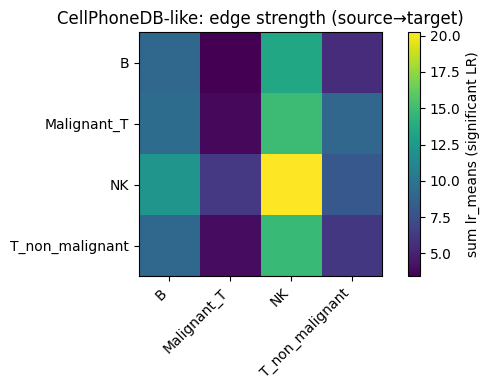

target,B,Malignant_T,NK,T_non_malignant
source,,,,
B,9.115857,3.433503,13.431883,5.594546
Malignant_T,9.353220,3.805833,14.953804,8.980952
NK,12.184135,6.214933,20.227093,8.027332
T_non_malignant,9.024472,4.000027,14.795763,6.138056


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

mat = edge.pivot(index="source", columns="target", values="sum_lr").fillna(0)

plt.figure(figsize=(6,4))
plt.imshow(mat.values)
plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha="right")
plt.yticks(range(mat.shape[0]), mat.index)
plt.colorbar(label="sum lr_means (significant LR)")
plt.title("CellPhoneDB-like: edge strength (source→target)")
plt.tight_layout()
plt.show()

mat

In [24]:
res_sig_nomif = res_sig[(res_sig["ligand"] != "MIF") & (res_sig["receptor"] != "CD74")].copy()

edge_nomif = (res_sig_nomif
    .groupby(["source","target"])
    .agg(
        n_sig=("lr_means","size"),
        sum_lr=("lr_means","sum"),
        mean_lr=("lr_means","mean"),
        top_lr=("lr_means","max"),
    )
    .reset_index()
)

print("sig with MIF/CD74:", res_sig.shape[0])
print("sig without MIF/CD74:", res_sig_nomif.shape[0])

edge_nomif.sort_values("sum_lr", ascending=False).head(20)

sig with MIF/CD74: 196
sig without MIF/CD74: 172


,source,target,n_sig,sum_lr,mean_lr,top_lr
10,NK,NK,26,17.846285,0.686396,1.604840
14,T_non_malignant,NK,19,12.545379,0.660283,1.639437
2,B,NK,17,12.445517,0.732089,1.889021
6,Malignant_T,NK,17,11.003445,0.647261,1.568467
11,NK,T_non_malignant,13,7.157812,0.550601,1.368160
8,NK,B,9,6.952072,0.772452,1.659527
9,NK,Malignant_T,12,6.214933,0.517911,1.006758
7,Malignant_T,T_non_malignant,9,5.404910,0.600546,1.331787
15,T_non_malignant,T_non_malignant,10,5.331100,0.533110,1.402758
3,B,T_non_malignant,6,4.783931,0.797322,1.652342


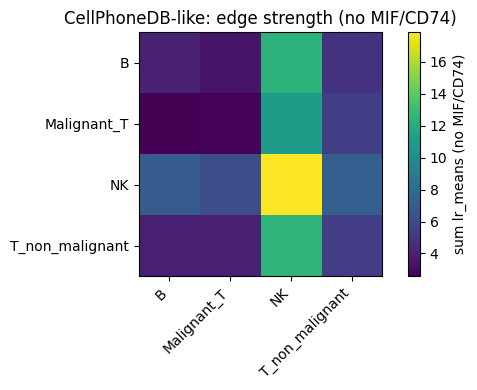

target,B,Malignant_T,NK,T_non_malignant
source,,,,
B,4.001373,3.433503,12.445517,4.783931
Malignant_T,2.573980,2.751926,11.003445,5.404910
NK,6.952072,6.214933,17.846285,7.157812
T_non_malignant,3.922832,4.000027,12.545379,5.331100


In [25]:
import matplotlib.pyplot as plt

mat2 = edge_nomif.pivot(index="source", columns="target", values="sum_lr").fillna(0)

plt.figure(figsize=(6,4))
plt.imshow(mat2.values)
plt.xticks(range(mat2.shape[1]), mat2.columns, rotation=45, ha="right")
plt.yticks(range(mat2.shape[0]), mat2.index)
plt.colorbar(label="sum lr_means (no MIF/CD74)")
plt.title("CellPhoneDB-like: edge strength (no MIF/CD74)")
plt.tight_layout()
plt.show()

mat2

In [ ]:
import liana as li

li.mt.geometric_mean(
    adata_ccc,
    groupby="ccc_celltype",
    resource_name="cellphonedb",
    expr_prop=0.1,
    use_raw=False,
    key_added="liana_gmean"
)

In [ ]:
li.mt.cellchat(
    adata_ccc,
    groupby="ccc_celltype",
    resource_name="cellphonedb",
    expr_prop=0.2,
    min_cells=30,
    de_method="t-test",
    n_perms=100,
    use_raw=False,
    n_jobs=1,
    key_added="liana_cellchat",
    verbose=True
)

In [32]:
res_cc = adata_ccc.uns["liana_cellchat"]
print("cellchat shape:", res_cc.shape)
print("columns:", res_cc.columns.tolist())
res_cc.head(10)

cellchat shape: (89, 13)
columns: ['ligand', 'ligand_complex', 'ligand_props', 'ligand_trimean', 'mat_max', 'receptor', 'receptor_complex', 'receptor_props', 'receptor_trimean', 'source', 'target', 'lr_probs', 'cellchat_pvals']


,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
7,MIF,MIF,0.736750,0.248441,8.010503,CD74,CD74,0.991354,0.573570,Malignant_T,B,0.221788,0.0
12,MIF,MIF,0.592920,0.136733,8.010503,CD74,CD74,0.991354,0.573570,NK,B,0.135585,0.0
0,MIF,MIF,0.585014,0.119099,8.010503,CD74,CD74,0.991354,0.573570,B,B,0.120201,0.0
17,MIF,MIF,0.585393,0.107900,8.010503,CD74,CD74,0.991354,0.573570,T_non_malignant,B,0.110143,0.0
56,MIF,MIF,0.736750,0.248441,8.010503,CD74,CD74,0.669617,0.190665,Malignant_T,NK,0.086539,0.0
67,HLA-E,HLA-E,0.806785,0.280882,8.010503,KLRK1,KLRK1,0.528024,0.150725,NK,NK,0.078062,0.0
72,HLA-E,HLA-E,0.719934,0.191137,8.010503,KLRK1,KLRK1,0.528024,0.150725,T_non_malignant,NK,0.054479,0.0
49,HLA-E,HLA-E,0.731988,0.189036,8.010503,KLRK1,KLRK1,0.528024,0.150725,B,NK,0.053912,0.0
59,HLA-E,HLA-E,0.769005,0.174833,8.010503,KLRK1,KLRK1,0.528024,0.150725,Malignant_T,NK,0.050065,0.0
63,MIF,MIF,0.592920,0.136733,8.010503,CD74,CD74,0.669617,0.190665,NK,NK,0.049556,0.0


In [33]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata_ccc,
    groupby="ccc_celltype",
    method="wilcoxon",
    use_raw=False
)

In [34]:
import numpy as np
import pandas as pd

rg = adata_ccc.uns["rank_genes_groups"]
groups = rg["names"].dtype.names

log2fc_map = {}
for g in groups:
    genes = pd.Series(rg["names"][g]).astype(str).values
    lfc = pd.Series(rg["logfoldchanges"][g]).astype(float).values
    log2fc_map[g] = dict(zip(genes, lfc))

print("Groups:", groups)
print("Example (first group):", list(log2fc_map[groups[0]].items())[:5])

Groups: ('B', 'Malignant_T', 'NK', 'T_non_malignant')
Example (first group): [('CD74', np.float64(6.91588020324707)), ('HLA-DRA', np.float64(6.713822841644287)), ('CD83', np.float64(6.390145301818848)), ('HLA-DRB1', np.float64(6.7111101150512695)), ('MS4A1', np.float64(10.786724090576172))]


In [36]:
import numpy as np

def add_log2fc(res_df, log2fc_map):
    res_df = res_df.copy()
    res_df["ligand_log2fc"] = [
        log2fc_map.get(s, {}).get(l, np.nan)
        for s, l in zip(res_df["source"], res_df["ligand"])
    ]
    res_df["receptor_log2fc"] = [
        log2fc_map.get(t, {}).get(r, np.nan)
        for t, r in zip(res_df["target"], res_df["receptor"])
    ]
    return res_df

In [37]:
res_g = adata_ccc.uns["liana_gmean"]
res_g2 = add_log2fc(res_g, log2fc_map)

res_g2[[
    "source","target","ligand","receptor",
    "ligand_log2fc","receptor_log2fc"
]].head(10)

,source,target,ligand,receptor,ligand_log2fc,receptor_log2fc
12,Malignant_T,B,MIF,CD74,1.673927,6.915880
28,NK,B,MIF,CD74,-1.241570,6.915880
0,B,B,MIF,CD74,-1.476158,6.915880
45,T_non_malignant,B,MIF,CD74,-1.653217,6.915880
163,Malignant_T,NK,MIF,CD74,1.673927,2.312714
25,Malignant_T,B,COPA,CD74,0.532780,6.915880
41,NK,B,COPA,CD74,-0.123035,6.915880
38,NK,B,PTPRC,CD22,2.073087,10.112377
211,NK,NK,HLA-E,KLRK1,1.097373,5.249048
159,B,NK,FAM3C,HLA-C,3.004208,1.914686


In [38]:
thr = 0.25

res_g_spec = res_g2[
    (res_g2["ligand_log2fc"] > thr) &
    (res_g2["receptor_log2fc"] > thr)
].copy()

print("gmean total:", res_g2.shape[0])
print("gmean log2FC-specific:", res_g_spec.shape[0])

cols = [c for c in res_g2.columns if "gmean" in c.lower() or "score" in c.lower() or "lr" in c.lower()]
print("Some score-like cols:", cols)

res_g_spec.sort_values(
    ["ligand_log2fc","receptor_log2fc"],
    ascending=False
)[["source","target","ligand","receptor","ligand_log2fc","receptor_log2fc"]].head(20)

gmean total: 296
gmean log2FC-specific: 112
Some score-like cols: ['lr_gmeans', 'gmean_pvals']


,source,target,ligand,receptor,ligand_log2fc,receptor_log2fc
105,NK,Malignant_T,NCAM1,FGFR1,10.111773,1.608617
98,NK,Malignant_T,KLRF1,CLEC2B,8.541832,0.433150
152,B,NK,FCER2,ITGAX,7.966617,4.615738
150,B,NK,FCER2,ITGAM,7.966617,2.204231
130,B,NK,ALOX5,ALOX5AP,5.951831,1.999977
111,NK,Malignant_T,CCL4,SLC7A1,5.579158,1.408222
314,T_non_malignant,T_non_malignant,TNF,ICOS,4.761069,3.370171
316,T_non_malignant,T_non_malignant,TNF,FAS,4.761069,1.747441
245,T_non_malignant,NK,TNF,NOTCH1,4.761069,0.780513
122,T_non_malignant,Malignant_T,TNF,VSIR,4.761069,0.732592


In [39]:
res_cc = adata_ccc.uns["liana_cellchat"]
res_cc2 = add_log2fc(res_cc, log2fc_map)

thr = 0.25
res_cc_spec = res_cc2[
    (res_cc2["ligand_log2fc"] > thr) &
    (res_cc2["receptor_log2fc"] > thr)
].copy()

print("cellchat total:", res_cc2.shape[0])
print("cellchat log2FC-specific:", res_cc_spec.shape[0])

res_cc_spec.sort_values(
    ["ligand_log2fc","receptor_log2fc"],
    ascending=False
)[["source","target","ligand","receptor","lr_probs","cellchat_pvals","ligand_log2fc","receptor_log2fc"]].head(20)

cellchat total: 89
cellchat log2FC-specific: 30


,source,target,ligand,receptor,lr_probs,cellchat_pvals,ligand_log2fc,receptor_log2fc
38,NK,Malignant_T,KLRF1,CLEC2B,0.014699,0.0,8.541832,0.433150
52,B,NK,FCER2,ITGAX,0.000000,1.0,7.966617,4.615738
40,NK,Malignant_T,CCL4,SLC7A1,0.005651,0.0,5.579158,1.408222
71,T_non_malignant,NK,CLEC2D,KLRB1,0.001415,0.0,3.457757,4.277719
78,B,T_non_malignant,FAM3C,CLEC2D,0.001370,0.0,3.004208,3.457757
4,B,B,FAM3C,CLEC2D,0.000000,1.0,3.004208,2.388304
55,B,NK,FAM3C,HLA-C,0.044312,0.0,3.004208,1.914686
80,B,T_non_malignant,FAM3C,HLA-C,0.036885,0.0,3.004208,1.246599
6,B,B,FAM3C,HLA-C,0.036501,0.0,3.004208,0.990659
24,B,Malignant_T,FAM3C,LAMP1,0.003096,0.0,3.004208,0.696030


gmean spec: 112
cellchat spec: 30
intersection: 30


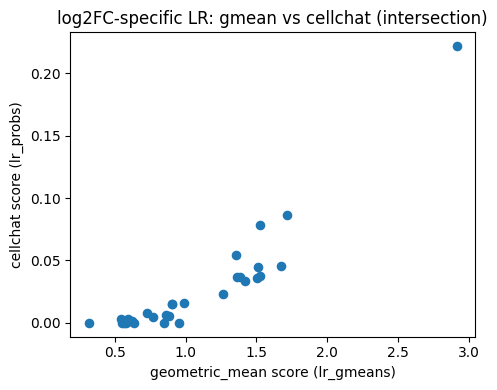

Spearman rho: 0.8934344875397736
Top15 overlap within intersection: 14 / 15
Top overlap examples: [('Malignant_T', 'B', 'COPA', 'CD74'), ('NK', 'Malignant_T', 'KLRF1', 'CLEC2B'), ('Malignant_T', 'NK', 'MIF', 'CD74'), ('NK', 'NK', 'HLA-E', 'KLRK1'), ('B', 'NK', 'FAM3C', 'HLA-C'), ('B', 'T_non_malignant', 'FAM3C', 'HLA-C'), ('T_non_malignant', 'B', 'PTPRC', 'CD22'), ('Malignant_T', 'B', 'MIF', 'CD74'), ('Malignant_T', 'NK', 'COPA', 'CD74'), ('B', 'B', 'PTPRC', 'CD22')]

Top discordant: high gmean, low cellchat


,source,target,ligand,receptor,gmean_score,cellchat_score,cellchat_pvals,rank_g,rank_c
13,NK,T_non_malignant,HLA-E,KLRK1,0.954128,0.000000,1.0,14.0,24.0
18,T_non_malignant,T_non_malignant,HLA-E,KLRK1,0.848980,0.000000,1.0,19.0,24.0
6,Malignant_T,T_non_malignant,MIF,CD74,1.502451,0.035817,0.0,7.0,10.0
3,NK,B,PTPRC,CD22,1.524891,0.037758,0.0,4.0,7.0
7,T_non_malignant,B,PTPRC,CD22,1.419707,0.033470,0.0,8.0,11.0
2,Malignant_T,B,COPA,CD74,1.676992,0.045253,0.0,3.0,5.0
21,NK,Malignant_T,TGFB1,TGFBR1,0.638824,0.000000,1.0,22.0,24.0
16,NK,Malignant_T,CCL4,SLC7A1,0.882728,0.005651,0.0,17.0,18.0
12,Malignant_T,NK,COPA,CD74,0.986760,0.015511,0.0,13.0,13.0
11,B,B,PTPRC,CD22,1.265282,0.022892,0.0,12.0,12.0



Top discordant: high cellchat, low gmean


,source,target,ligand,receptor,gmean_score,cellchat_score,cellchat_pvals,rank_g,rank_c
28,B,Malignant_T,FAM3C,LAMP1,0.544786,0.003096,0.0,29.0,21.0
10,T_non_malignant,NK,HLA-E,KLRK1,1.354886,0.054479,0.0,11.0,4.0
29,Malignant_T,NK,BAG6,NCR3,0.314592,0.000000,1.0,30.0,24.0
20,Malignant_T,Malignant_T,LGALS9,CD47,0.727823,0.007788,0.0,21.0,16.0
24,NK,NK,ITGAL,ICAM3,0.593588,0.003405,0.0,25.0,20.0
27,B,NK,FCER2,ITGAX,0.549620,0.000000,1.0,28.0,24.0
26,B,B,FAM3C,CLEC2D,0.565568,0.000000,1.0,27.0,24.0
25,B,NK,CLEC2D,KLRB1,0.576925,0.000000,1.0,26.0,24.0
4,NK,NK,HLA-E,KLRK1,1.522692,0.078062,0.0,5.0,3.0
14,NK,Malignant_T,KLRF1,CLEC2B,0.900421,0.014699,0.0,15.0,14.0


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

g = res_g2.copy()
c = res_cc2.copy()

thr = 0.25
g = g[(g["ligand_log2fc"] > thr) & (g["receptor_log2fc"] > thr)].copy()
c = c[(c["ligand_log2fc"] > thr) & (c["receptor_log2fc"] > thr)].copy()

keys = ["source","target","ligand","receptor"]

g2 = g[keys + ["lr_gmeans"]].rename(columns={"lr_gmeans":"gmean_score"})
c2 = c[keys + ["lr_probs","cellchat_pvals"]].rename(columns={"lr_probs":"cellchat_score"})

m = g2.merge(c2, on=keys, how="inner")
print("gmean spec:", g2.shape[0])
print("cellchat spec:", c2.shape[0])
print("intersection:", m.shape[0])

# scatter
plt.figure(figsize=(5,4))
plt.scatter(m["gmean_score"], m["cellchat_score"], s=35)
plt.xlabel("geometric_mean score (lr_gmeans)")
plt.ylabel("cellchat score (lr_probs)")
plt.title("log2FC-specific LR: gmean vs cellchat (intersection)")
plt.tight_layout()
plt.show()

rho = m["gmean_score"].corr(m["cellchat_score"], method="spearman")
print("Spearman rho:", rho)

N = min(15, m.shape[0])
top_g = set(m.sort_values("gmean_score", ascending=False).head(N).apply(lambda r: tuple(r[k] for k in keys), axis=1))
top_c = set(m.sort_values("cellchat_score", ascending=False).head(N).apply(lambda r: tuple(r[k] for k in keys), axis=1))

print(f"Top{N} overlap within intersection:", len(top_g & top_c), "/", N)
print("Top overlap examples:", list(top_g & top_c)[:10])

m["rank_g"] = m["gmean_score"].rank(ascending=False, method="min")
m["rank_c"] = m["cellchat_score"].rank(ascending=False, method="min")
m["rank_diff"] = m["rank_g"] - m["rank_c"]

print("\nTop discordant: high gmean, low cellchat")
display(m.sort_values("rank_diff").head(10)[keys + ["gmean_score","cellchat_score","cellchat_pvals","rank_g","rank_c"]])

print("\nTop discordant: high cellchat, low gmean")
display(m.sort_values("rank_diff", ascending=False).head(10)[keys + ["gmean_score","cellchat_score","cellchat_pvals","rank_g","rank_c"]])

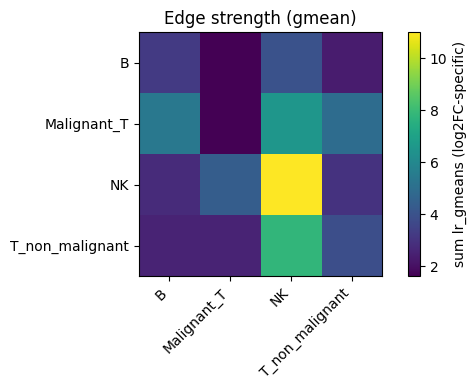

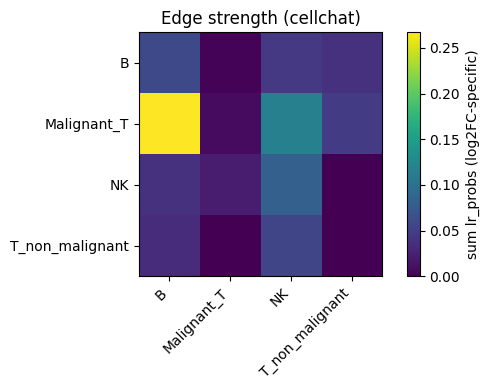

Top edges gmean:


,source,target,n,sum_score,mean_score,top
10,NK,NK,19,10.988605,0.578348,1.522692
14,T_non_malignant,NK,13,7.768301,0.597562,1.354886
6,Malignant_T,NK,10,6.524355,0.652436,1.715310
4,Malignant_T,B,3,5.349092,1.783031,2.915158
7,Malignant_T,T_non_malignant,7,4.913856,0.701979,1.502451
9,NK,Malignant_T,9,4.361026,0.484558,0.900421
2,B,NK,7,3.972664,0.567523,1.509331
15,T_non_malignant,T_non_malignant,8,3.849025,0.481128,0.848980
0,B,B,3,3.193861,1.064620,1.363011
11,NK,T_non_malignant,7,3.003631,0.429090,0.954128


Top edges cellchat:


,source,target,n,sum_score,mean_score,top
4,Malignant_T,B,2,0.267040,0.133520,0.221788
6,Malignant_T,NK,4,0.116750,0.029187,0.086539
10,NK,NK,2,0.081467,0.040733,0.078062
0,B,B,3,0.059393,0.019798,0.036501
13,T_non_malignant,NK,2,0.055894,0.027947,0.054479
7,Malignant_T,T_non_malignant,3,0.046584,0.015528,0.035817
2,B,NK,3,0.044312,0.014771,0.044312
3,B,T_non_malignant,2,0.038254,0.019127,0.036885
8,NK,B,1,0.037758,0.037758,0.037758
12,T_non_malignant,B,1,0.033470,0.033470,0.033470


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

thr = 0.25
keys_edge = ["source","target"]

# gmean edges
g_edge = res_g2[(res_g2.ligand_log2fc > thr) & (res_g2.receptor_log2fc > thr)].copy()
edge_g = (g_edge.groupby(keys_edge)
          .agg(n=("lr_gmeans","size"),
               sum_score=("lr_gmeans","sum"),
               mean_score=("lr_gmeans","mean"),
               top=("lr_gmeans","max"))
          .reset_index())
mat_g = edge_g.pivot(index="source", columns="target", values="sum_score").fillna(0)

plt.figure(figsize=(6,4))
plt.imshow(mat_g.values)
plt.xticks(range(mat_g.shape[1]), mat_g.columns, rotation=45, ha="right")
plt.yticks(range(mat_g.shape[0]), mat_g.index)
plt.colorbar(label="sum lr_gmeans (log2FC-specific)")
plt.title("Edge strength (gmean)")
plt.tight_layout()
plt.show()

# cellchat edges
c_edge = res_cc2[(res_cc2.ligand_log2fc > thr) & (res_cc2.receptor_log2fc > thr)].copy()
edge_c = (c_edge.groupby(keys_edge)
          .agg(n=("lr_probs","size"),
               sum_score=("lr_probs","sum"),
               mean_score=("lr_probs","mean"),
               top=("lr_probs","max"))
          .reset_index())
mat_c = edge_c.pivot(index="source", columns="target", values="sum_score").fillna(0)

plt.figure(figsize=(6,4))
plt.imshow(mat_c.values)
plt.xticks(range(mat_c.shape[1]), mat_c.columns, rotation=45, ha="right")
plt.yticks(range(mat_c.shape[0]), mat_c.index)
plt.colorbar(label="sum lr_probs (log2FC-specific)")
plt.title("Edge strength (cellchat)")
plt.tight_layout()
plt.show()

print("Top edges gmean:")
display(edge_g.sort_values("sum_score", ascending=False).head(10))

print("Top edges cellchat:")
display(edge_c.sort_values("sum_score", ascending=False).head(10))

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
/tmp/ipython-input-1859076804.py:13: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.


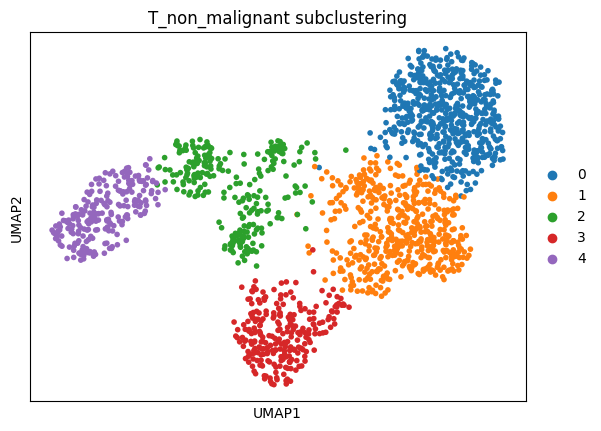

In [42]:
import scanpy as sc

t = adata_ccc[adata_ccc.obs["ccc_celltype"]=="T_non_malignant"].copy()

sc.pp.normalize_total(t, target_sum=1e4)
sc.pp.log1p(t)
sc.pp.highly_variable_genes(t, n_top_genes=2000)
t = t[:, t.var.highly_variable].copy()
sc.pp.scale(t, max_value=10)
sc.tl.pca(t, n_comps=30)
sc.pp.neighbors(t, n_neighbors=15, n_pcs=30)
sc.tl.umap(t, min_dist=0.3)
sc.tl.leiden(t, resolution=0.5)

sc.pl.umap(t, color="leiden", title="T_non_malignant subclustering")

In [ ]:
import scanpy as sc
import pandas as pd

counts = t.obs["leiden"].value_counts()
print(counts.sort_index())
print("n clusters:", counts.shape[0])
print("singletons:", (counts==1).sum())

min_cells = 10
keep = counts[counts >= min_cells].index
t2 = t[t.obs["leiden"].isin(keep)].copy()

print("t2 shape:", t2.shape, "kept clusters:", len(keep))

sc.tl.rank_genes_groups(t2, groupby="leiden", method="wilcoxon", use_raw=False)
sc.pl.rank_genes_groups(t2, n_genes=15, sharey=False)

rg = t2.uns["rank_genes_groups"]
groups = rg["names"].dtype.names

top = []
for g in groups:
    genes = pd.Series(rg["names"][g][:10]).astype(str).values
    lfc = pd.Series(rg["logfoldchanges"][g][:10]).astype(float).values
    pvals = pd.Series(rg["pvals_adj"][g][:10]).astype(float).values
    top.append(pd.DataFrame({"cluster": g, "gene": genes, "log2fc": lfc, "p_adj": pvals}))

top_df = pd.concat(top, ignore_index=True)
top_df.head(40)

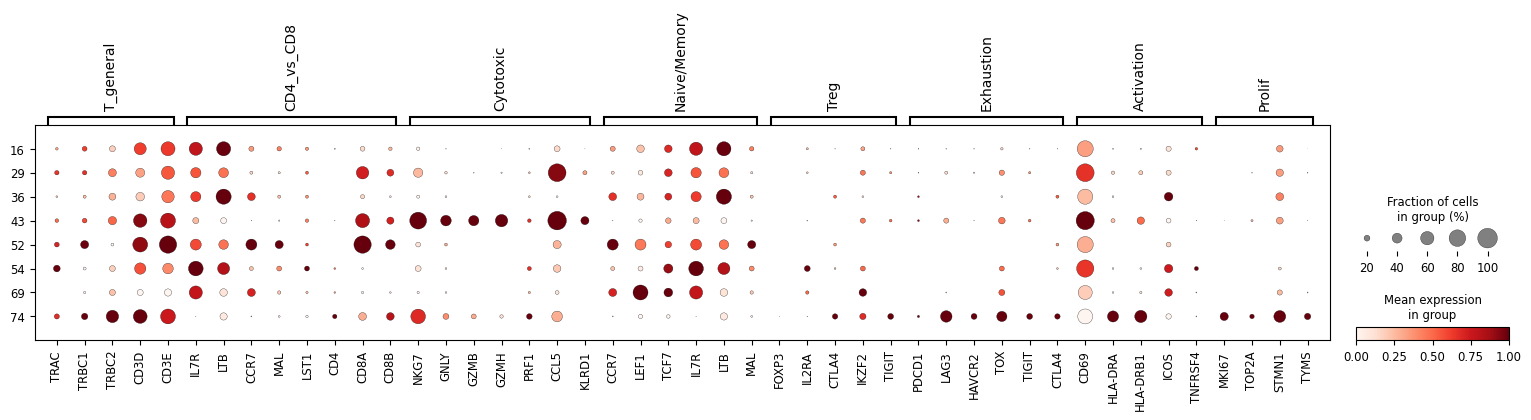

In [50]:
import scanpy as sc

# маркерные панели
markers = {
    "T_general": ["TRAC","TRBC1","TRBC2","CD3D","CD3E"],
    "CD4_vs_CD8": ["IL7R","LTB","CCR7","MAL","LST1","CD4","CD8A","CD8B"],
    "Cytotoxic": ["NKG7","GNLY","GZMB","GZMH","PRF1","CCL5","KLRD1"],
    "Naive/Memory": ["CCR7","LEF1","TCF7","IL7R","LTB","MAL"],
    "Treg": ["FOXP3","IL2RA","CTLA4","IKZF2","TIGIT"],
    "Exhaustion": ["PDCD1","LAG3","HAVCR2","TOX","TIGIT","CTLA4"],
    "Activation": ["CD69","HLA-DRA","HLA-DRB1","ICOS","TNFRSF4"],
    "Prolif": ["MKI67","TOP2A","STMN1","TYMS"]
}

sc.pl.dotplot(
    t2,
    var_names=markers,
    groupby="leiden",
    standard_scale="var",
    dendrogram=False
)

In [52]:
mapping = {
    "43": "T_CD8_Cytotoxic",
    "29": "T_CD8_Memory",
    "74": "T_CD4_Naive",
    "16": "T_Resting",
    "69": "T_Exhausted",
    "52": "T_CD4_Activated",
    "54": "T_CD4_Activated",

}


adata_ccc.obs["ccc_celltype_refined"] = adata_ccc.obs["ccc_celltype"].astype(str)

refined_t = t2.obs["leiden"].astype(str).map(mapping)

refined_t = refined_t.fillna("T_Other")

adata_ccc.obs.loc[refined_t.index, "ccc_celltype_refined"] = refined_t

adata_ccc.obs["ccc_celltype_refined"].value_counts()

,count
ccc_celltype_refined,
Malignant_T,13641
T_Resting,947
NK,678
T_CD8_Cytotoxic,348
B,347
T_CD4_Naive,328
T_CD8_Memory,73
T_Exhausted,53
T_CD4_Activated,38


In [53]:
mask_left = (adata_ccc.obs["ccc_celltype"]=="T_non_malignant") & (adata_ccc.obs["ccc_celltype_refined"]=="T_non_malignant")
adata_ccc.obs.loc[mask_left, "ccc_celltype_refined"] = "T_Other"

adata_ccc.obs["ccc_celltype_refined"].value_counts()

,count
ccc_celltype_refined,
Malignant_T,13641
T_Resting,947
NK,678
T_CD8_Cytotoxic,348
B,347
T_CD4_Naive,328
T_CD8_Memory,73
T_Exhausted,53
T_CD4_Activated,38


In [54]:
t_all = adata_ccc[
    adata_ccc.obs["ccc_celltype_refined"].str.startswith("T_") |
    (adata_ccc.obs["ccc_celltype_refined"]=="Malignant_T")
].copy()

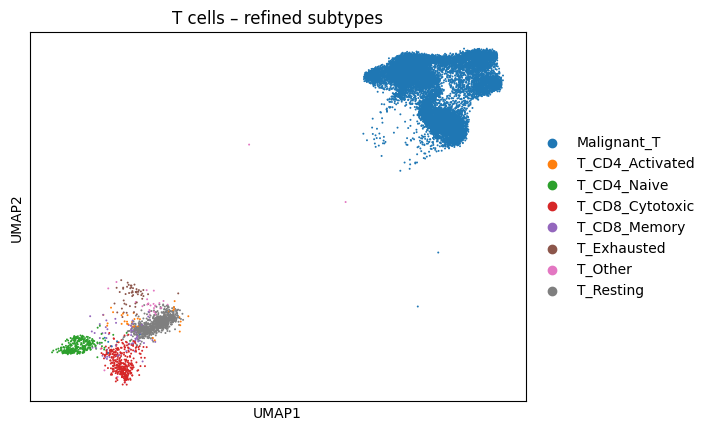

In [55]:
sc.pl.umap(
    t_all,
    color="ccc_celltype_refined",
    size=8,
    legend_loc="right margin",
    title="T cells – refined subtypes",
)

In [56]:
adata_ccc.obs["ccc_celltype_refined"].value_counts()

,count
ccc_celltype_refined,
Malignant_T,13641
T_Resting,947
NK,678
T_CD8_Cytotoxic,348
B,347
T_CD4_Naive,328
T_CD8_Memory,73
T_Exhausted,53
T_CD4_Activated,38


In [57]:
import liana as li

li.mt.geometric_mean(
    adata_ccc,
    groupby="ccc_celltype_refined",
    resource_name="cellphonedb",
    expr_prop=0.2,
    min_cells=30,
    use_raw=False,
    key_added="liana_gmean_refined"
)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:266: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [58]:
res_gr = adata_ccc.uns["liana_gmean_refined"]
print(res_gr.shape)
res_gr.head(10)

(482, 12)


,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_gmeans,gmean_pvals
7,MIF,MIF,1.948565,0.736750,CD74,CD74,4.361232,0.991354,Malignant_T,B,2.915158,0.0
12,MIF,MIF,1.161093,0.592920,CD74,CD74,4.361232,0.991354,NK,B,2.250288,0.0
213,MIF,MIF,1.948565,0.736750,CD74,CD74,2.571052,0.801829,Malignant_T,T_CD4_Naive,2.238272,0.0
30,MIF,MIF,1.091128,0.616438,CD74,CD74,4.361232,0.991354,T_CD8_Memory,B,2.181436,0.0
39,MIF,MIF,1.075048,0.629356,CD74,CD74,4.361232,0.991354,T_Resting,B,2.165303,0.0
0,MIF,MIF,1.043746,0.585014,CD74,CD74,4.361232,0.991354,B,B,2.133546,0.0
26,MIF,MIF,1.005610,0.563218,CD74,CD74,4.361232,0.991354,T_CD8_Cytotoxic,B,2.094206,0.0
20,MIF,MIF,0.991050,0.521341,CD74,CD74,4.361232,0.991354,T_CD4_Naive,B,2.078990,0.0
37,MIF,MIF,0.977270,0.529412,CD74,CD74,4.361232,0.991354,T_Other,B,2.064486,0.0
36,COPA,COPA,0.930835,0.452830,CD74,CD74,4.361232,0.991354,T_Exhausted,B,2.014842,0.0


In [59]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata_ccc,
    groupby="ccc_celltype_refined",
    method="wilcoxon",
    use_raw=False
)

In [60]:
import numpy as np
import pandas as pd

rg = adata_ccc.uns["rank_genes_groups"]
groups = rg["names"].dtype.names
print("Groups:", groups)

log2fc_map_refined = {}
for g in groups:
    genes = pd.Series(rg["names"][g]).astype(str).values
    lfc = pd.Series(rg["logfoldchanges"][g]).astype(float).values
    log2fc_map_refined[g] = dict(zip(genes, lfc))

res_gr = adata_ccc.uns["liana_gmean_refined"]
res_gr2 = add_log2fc(res_gr, log2fc_map_refined)

res_gr2[["source","target","ligand","receptor","ligand_log2fc","receptor_log2fc","lr_gmeans","gmean_pvals"]].head(10)

Groups: ('B', 'Malignant_T', 'NK', 'T_CD4_Activated', 'T_CD4_Naive', 'T_CD8_Cytotoxic', 'T_CD8_Memory', 'T_Exhausted', 'T_Other', 'T_Resting')


,source,target,ligand,receptor,ligand_log2fc,receptor_log2fc,lr_gmeans,gmean_pvals
7,Malignant_T,B,MIF,CD74,1.673927,6.915880,2.915158,0.0
12,NK,B,MIF,CD74,-1.241570,6.915880,2.250288,0.0
213,Malignant_T,T_CD4_Naive,MIF,CD74,1.673927,4.090491,2.238272,0.0
30,T_CD8_Memory,B,MIF,CD74,-1.349474,6.915880,2.181436,0.0
39,T_Resting,B,MIF,CD74,-1.454727,6.915880,2.165303,0.0
0,B,B,MIF,CD74,-1.476158,6.915880,2.133546,0.0
26,T_CD8_Cytotoxic,B,MIF,CD74,-1.563487,6.915880,2.094206,0.0
20,T_CD4_Naive,B,MIF,CD74,-1.595538,6.915880,2.078990,0.0
37,T_Other,B,MIF,CD74,-1.602013,6.915880,2.064486,0.0
36,T_Exhausted,B,COPA,CD74,0.850312,6.915880,2.014842,0.0


In [61]:
import numpy as np
import pandas as pd

res = res_gr2.copy()

res["pval_adj0"] = res["gmean_pvals"].replace(0.0, 1e-6)

thr = 0.25

res_spec = res[
    (res["ligand_log2fc"] > thr) &
    (res["receptor_log2fc"] > thr) &
    (res["ligand_props"] >= 0.2) &
    (res["receptor_props"] >= 0.2)
].copy()

print("gmean refined total:", res.shape[0])
print("gmean refined log2FC-specific:", res_spec.shape[0])

edge = (res_spec
    .groupby(["source","target"])
    .agg(
        n_sig=("lr_gmeans","size"),
        sum_score=("lr_gmeans","sum"),
        mean_score=("lr_gmeans","mean"),
        top_score=("lr_gmeans","max"),
    )
    .reset_index()
)

edge.sort_values("sum_score", ascending=False).head(15)

gmean refined total: 482
gmean refined log2FC-specific: 167


,source,target,n_sig,sum_score,mean_score,top_score
42,T_CD4_Naive,T_CD8_Cytotoxic,7,6.519605,0.931372,1.619020
37,T_CD4_Naive,B,4,5.482770,1.370692,1.811905
39,T_CD4_Naive,NK,5,5.367363,1.073473,1.606613
43,T_CD4_Naive,T_CD8_Memory,5,5.254224,1.050845,1.464385
41,T_CD4_Naive,T_CD4_Naive,5,4.868333,0.973667,1.461280
14,Malignant_T,T_CD4_Naive,4,4.786414,1.196604,2.238272
10,Malignant_T,B,2,4.592150,2.296075,2.915158
52,T_CD8_Cytotoxic,T_CD8_Cytotoxic,5,3.944716,0.788943,1.450921
12,Malignant_T,NK,4,3.917083,0.979271,1.715310
64,T_Exhausted,B,2,3.737484,1.868742,2.014842


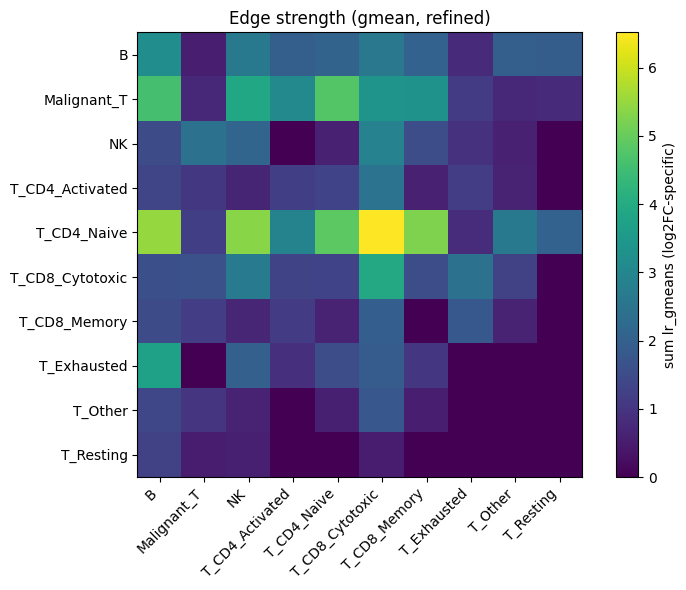

target,B,Malignant_T,NK,T_CD4_Activated,T_CD4_Naive,T_CD8_Cytotoxic,T_CD8_Memory,T_Exhausted,T_Other,T_Resting
source,,,,,,,,,,
B,3.193861,0.544786,2.635877,1.978289,2.065171,2.607991,2.042903,0.785511,1.970397,1.923547
Malignant_T,4.592150,0.727823,3.917083,3.076725,4.786414,3.374323,3.325571,1.132480,0.747938,0.775471
NK,1.524891,2.421972,2.116280,0.000000,0.602513,2.892726,1.532748,0.934480,0.599627,0.000000
T_CD4_Activated,1.361251,1.045127,0.680202,1.221436,1.319118,2.494508,0.594870,1.175999,0.656534,0.000000
T_CD4_Naive,5.482770,1.210305,5.367363,2.918117,4.868333,6.519605,5.254224,0.836140,2.636379,2.047526
T_CD8_Cytotoxic,1.579410,1.629120,2.677590,1.329722,1.320023,3.944716,1.544982,2.421272,1.289608,0.000000
T_CD8_Memory,1.510535,1.187253,0.705114,1.151196,0.642716,1.943569,0.000000,1.790355,0.618780,0.000000
T_Exhausted,3.737484,0.000000,1.986838,0.903302,1.547005,1.886905,1.030760,0.000000,0.000000,0.000000
T_Other,1.390812,0.983452,0.649232,0.000000,0.580499,1.779813,0.541947,0.000000,0.000000,0.000000


In [62]:
import matplotlib.pyplot as plt

mat = edge.pivot(index="source", columns="target", values="sum_score").fillna(0)

plt.figure(figsize=(8,6))
plt.imshow(mat.values)
plt.xticks(range(mat.shape[1]), mat.columns, rotation=45, ha="right")
plt.yticks(range(mat.shape[0]), mat.index)
plt.colorbar(label="sum lr_gmeans (log2FC-specific)")
plt.title("Edge strength (gmean, refined)")
plt.tight_layout()
plt.show()

mat

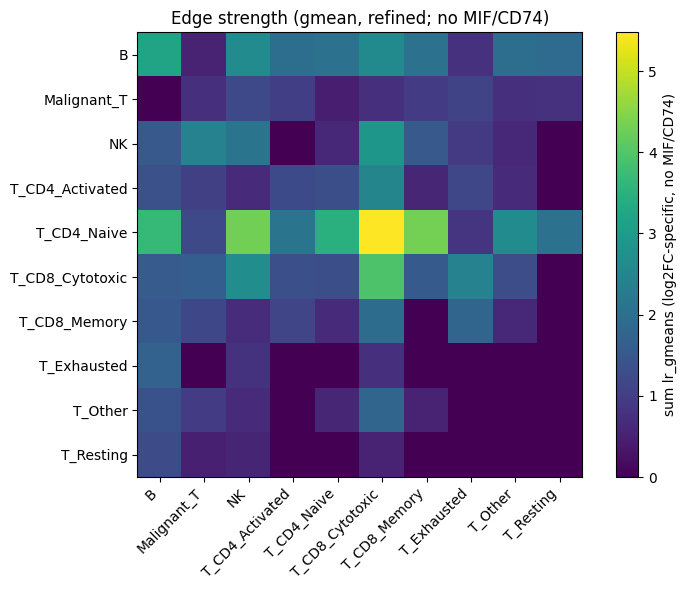

spec LRs total: 167
spec LRs without MIF/CD74: 142


,source,target,n_sig,sum_score,mean_score,top_score
41,T_CD4_Naive,T_CD8_Cytotoxic,6,5.478013,0.913002,1.619020
42,T_CD4_Naive,T_CD8_Memory,4,4.327283,1.081821,1.464385
38,T_CD4_Naive,NK,4,4.301219,1.075305,1.606613
51,T_CD8_Cytotoxic,T_CD8_Cytotoxic,5,3.944716,0.788943,1.450921
36,T_CD4_Naive,B,3,3.670865,1.223622,1.617983
40,T_CD4_Naive,T_CD4_Naive,4,3.477144,0.869286,1.461280
0,B,B,3,3.193861,1.064620,1.363011
23,NK,T_CD8_Cytotoxic,3,2.892726,0.964242,1.439432
48,T_CD8_Cytotoxic,NK,3,2.677590,0.892530,1.534845
44,T_CD4_Naive,T_Other,3,2.636379,0.878793,1.419922


In [63]:
res_spec_nomif = res_spec[(res_spec["ligand"] != "MIF") & (res_spec["receptor"] != "CD74")].copy()

edge_nomif = (res_spec_nomif
    .groupby(["source","target"])
    .agg(
        n_sig=("lr_gmeans","size"),
        sum_score=("lr_gmeans","sum"),
        mean_score=("lr_gmeans","mean"),
        top_score=("lr_gmeans","max"),
    )
    .reset_index()
)

mat_nomif = edge_nomif.pivot(index="source", columns="target", values="sum_score").fillna(0)

plt.figure(figsize=(8,6))
plt.imshow(mat_nomif.values)
plt.xticks(range(mat_nomif.shape[1]), mat_nomif.columns, rotation=45, ha="right")
plt.yticks(range(mat_nomif.shape[0]), mat_nomif.index)
plt.colorbar(label="sum lr_gmeans (log2FC-specific, no MIF/CD74)")
plt.title("Edge strength (gmean, refined; no MIF/CD74)")
plt.tight_layout()
plt.show()

print("spec LRs total:", res_spec.shape[0])
print("spec LRs without MIF/CD74:", res_spec_nomif.shape[0])

edge_nomif.sort_values("sum_score", ascending=False).head(15)

In [64]:
top_edges = edge_nomif.sort_values("sum_score", ascending=False).head(6)[["source","target"]]
top_edges

top_pairs = (
    res_spec_nomif
    .merge(top_edges, on=["source","target"], how="inner")
    .sort_values(["source","target","lr_gmeans"], ascending=[True, True, False])
)

top_pairs[[
    "source","target","ligand","receptor",
    "ligand_log2fc","receptor_log2fc",
    "ligand_props","receptor_props",
    "lr_gmeans","gmean_pvals"
]].groupby(["source","target"]).head(10)

,source,target,ligand,receptor,ligand_log2fc,receptor_log2fc,ligand_props,receptor_props,lr_gmeans,gmean_pvals
1,T_CD4_Naive,B,PTPRC,CD22,2.492212,10.112377,0.935976,0.487032,1.617983,0.0
7,T_CD4_Naive,B,FAM3C,HLA-C,3.281662,0.990659,0.432927,0.925072,1.450861,0.0
19,T_CD4_Naive,B,FAM3C,CLEC2D,3.281662,2.388304,0.432927,0.239193,0.602021,0.0
2,T_CD4_Naive,NK,FAM3C,HLA-C,3.281662,1.914686,0.432927,0.938053,1.606613,0.0
5,T_CD4_Naive,NK,HLA-E,KLRK1,0.767074,5.249048,0.804878,0.528024,1.454777,0.0
15,T_CD4_Naive,NK,CLEC2D,KLRB1,3.200949,4.277719,0.362805,0.362832,0.706274,0.0
24,T_CD4_Naive,NK,ITGAL,ICAM3,1.451410,0.282144,0.350610,0.275811,0.533555,0.0
4,T_CD4_Naive,T_CD4_Naive,FAM3C,HLA-C,3.281662,1.046643,0.432927,0.911585,1.461280,0.0
11,T_CD4_Naive,T_CD4_Naive,LCK,CD8A,1.259759,3.348734,0.487805,0.295732,0.737289,0.0
12,T_CD4_Naive,T_CD4_Naive,FAM3C,CLEC2D,3.281662,3.200949,0.432927,0.362805,0.736997,0.0


In [66]:
from liana.method import logfc

logfc(
    adata_ccc,
    groupby="ccc_celltype_refined",
    resource_name="cellphonedb",
    use_raw=False,
    key_added="liana_logfc"
)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/usr/local/lib/python3.12/dist-packages/liana/method/sc/_liana_pipe.py:293: FutureWarning: Use uns (e.g. `k in adata.uns` or `sorted(adata.uns)`) instead of AnnData.uns_keys, AnnData.uns_keys is deprecated and will be removed in the future.
/usr/local/lib/python3.12/dist-packages/liana/method/sc/_liana_pipe.py:296: FutureWarning: Use uns (e.g. `k in a

In [67]:
adata_ccc.uns["liana_logfc"]

,ligand,ligand_complex,ligand_logfc,ligand_means,ligand_props,receptor,receptor_complex,receptor_logfc,receptor_means,receptor_props,source,target,lr_logfc
12,MIF,MIF,1.287867,1.948565,0.736750,CD74,CD74,5.040832,4.361232,0.991354,Malignant_T,B,3.164350
102,COPA,COPA,0.828694,0.930835,0.452830,CD74,CD74,5.040832,4.361232,0.991354,T_Exhausted,B,2.934763
70,COPA,COPA,0.374365,0.752769,0.457317,CD74,CD74,5.040832,4.361232,0.991354,T_CD4_Naive,B,2.707599
25,COPA,COPA,0.115391,0.644841,0.501723,CD74,CD74,5.040832,4.361232,0.991354,Malignant_T,B,2.578112
85,COPA,COPA,0.110279,0.568132,0.310345,CD74,CD74,5.040832,4.361232,0.991354,T_CD8_Cytotoxic,B,2.575556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,MIF,MIF,-1.196109,1.075048,0.629356,CD74,CD74,-3.200070,0.356063,0.240158,T_Resting,Malignant_T,-2.198090
194,MIF,MIF,-1.243457,0.991050,0.521341,CD74,CD74,-3.200070,0.356063,0.240158,T_CD4_Naive,Malignant_T,-2.221764
259,MIF,MIF,-1.271398,0.977270,0.529412,CD74,CD74,-3.200070,0.356063,0.240158,T_Other,Malignant_T,-2.235734
178,MIF,MIF,-1.527263,0.870434,0.526316,CD74,CD74,-3.200070,0.356063,0.240158,T_CD4_Activated,Malignant_T,-2.363667


gmean: (482, 6) logfc: (1353, 5) intersection: (482, 7)


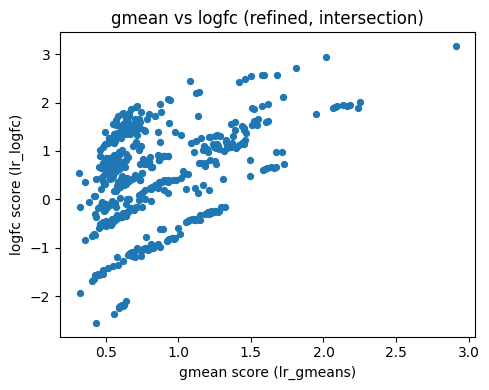

Spearman rho: 0.3485205246175765


In [68]:
import pandas as pd
import matplotlib.pyplot as plt

g = adata_ccc.uns["liana_gmean_refined"].copy()
l = adata_ccc.uns["liana_logfc"].copy()

keys = ["source","target","ligand","receptor"]

g2 = g[keys + ["lr_gmeans", "gmean_pvals"]].rename(columns={"lr_gmeans":"gmean_score"})
l2 = l[keys + ["lr_logfc"]].rename(columns={"lr_logfc":"logfc_score"})

m = g2.merge(l2, on=keys, how="inner")
print("gmean:", g2.shape, "logfc:", l2.shape, "intersection:", m.shape)

plt.figure(figsize=(5,4))
plt.scatter(m["gmean_score"], m["logfc_score"], s=18)
plt.xlabel("gmean score (lr_gmeans)")
plt.ylabel("logfc score (lr_logfc)")
plt.title("gmean vs logfc (refined, intersection)")
plt.tight_layout()
plt.show()

rho = m["gmean_score"].corr(m["logfc_score"], method="spearman")
print("Spearman rho:", rho)

In [71]:
from liana.method import cellchat

cellchat(
    adata_ccc,
    groupby="ccc_celltype_refined",
    resource_name="cellphonedb",
    expr_prop=0.2,
    min_cells=30,
    use_raw=False,
    key_added="liana_cellchat_refined",
    n_perms=200,
    n_jobs=8,
    seed=1337,
    verbose=True
)

/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_pre.py:149: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Generating ligand-receptor stats for 16487 samples and 681 features


/usr/local/lib/python3.12/dist-packages/liana/method/_pipe_utils/_get_mean_perms.py:43: ImplicitModificationWarning: Modifying `X` on a view results in data being overridden
100%|██████████| 200/200 [02:15<00:00,  1.47it/s]


In [72]:
res_ccr = adata_ccc.uns["liana_cellchat_refined"]
print("cellchat refined shape:", res_ccr.shape)
print(res_ccr.columns.tolist())
res_ccr.head(10)

cellchat refined shape: (482, 13)
['ligand', 'ligand_complex', 'ligand_props', 'ligand_trimean', 'mat_max', 'receptor', 'receptor_complex', 'receptor_props', 'receptor_trimean', 'source', 'target', 'lr_probs', 'cellchat_pvals']


,ligand,ligand_complex,ligand_props,ligand_trimean,mat_max,receptor,receptor_complex,receptor_props,receptor_trimean,source,target,lr_probs,cellchat_pvals
7,MIF,MIF,0.736750,0.248441,8.010503,CD74,CD74,0.991354,0.573570,Malignant_T,B,0.221788,0.0
213,MIF,MIF,0.736750,0.248441,8.010503,CD74,CD74,0.801829,0.359415,Malignant_T,T_CD4_Naive,0.151526,0.0
12,MIF,MIF,0.592920,0.136733,8.010503,CD74,CD74,0.991354,0.573570,NK,B,0.135585,0.0
30,MIF,MIF,0.616438,0.124523,8.010503,CD74,CD74,0.991354,0.573570,T_CD8_Memory,B,0.124991,0.0
0,MIF,MIF,0.585014,0.119099,8.010503,CD74,CD74,0.991354,0.573570,B,B,0.120201,0.0
39,MIF,MIF,0.629356,0.117967,8.010503,CD74,CD74,0.991354,0.573570,T_Resting,B,0.119195,0.0
26,MIF,MIF,0.563218,0.104885,8.010503,CD74,CD74,0.991354,0.573570,T_CD8_Cytotoxic,B,0.107396,0.0
20,MIF,MIF,0.521341,0.087637,8.010503,CD74,CD74,0.991354,0.573570,T_CD4_Naive,B,0.091348,0.0
221,MIF,MIF,0.592920,0.136733,8.010503,CD74,CD74,0.801829,0.359415,NK,T_CD4_Naive,0.089492,0.0
111,MIF,MIF,0.736750,0.248441,8.010503,CD74,CD74,0.669617,0.190665,Malignant_T,NK,0.086539,0.0


In [73]:
res_ccr2 = add_log2fc(res_ccr, log2fc_map_refined)

thr = 0.25
res_ccr_spec = res_ccr2[
    (res_ccr2["ligand_log2fc"] > thr) &
    (res_ccr2["receptor_log2fc"] > thr) &
    (res_ccr2["ligand_props"] >= 0.2) &
    (res_ccr2["receptor_props"] >= 0.2)
].copy()

print("cellchat refined total:", res_ccr2.shape[0])
print("cellchat refined log2FC-specific:", res_ccr_spec.shape[0])

res_ccr_spec[[
    "source","target","ligand","receptor",
    "ligand_log2fc","receptor_log2fc",
    "lr_probs","cellchat_pvals"
]].sort_values(["lr_probs"], ascending=False).head(12)

cellchat refined total: 482
cellchat refined log2FC-specific: 169


,source,target,ligand,receptor,ligand_log2fc,receptor_log2fc,lr_probs,cellchat_pvals
7,Malignant_T,B,MIF,CD74,1.673927,6.915880,0.221788,0.0
213,Malignant_T,T_CD4_Naive,MIF,CD74,1.673927,4.090491,0.151526,0.0
111,Malignant_T,NK,MIF,CD74,1.673927,2.312714,0.086539,0.0
371,NK,T_CD8_Memory,HLA-E,KLRK1,1.097373,4.459290,0.086050,0.0
389,T_CD8_Cytotoxic,T_CD8_Memory,HLA-E,KLRK1,1.128312,4.459290,0.085555,0.0
282,Malignant_T,T_CD8_Cytotoxic,MIF,CD74,1.673927,2.110888,0.085321,0.0
122,NK,NK,HLA-E,KLRK1,1.097373,5.249048,0.078062,0.0
382,T_CD4_Naive,T_CD8_Memory,HLA-E,KLRK1,0.767074,4.459290,0.077902,0.0
142,T_CD8_Cytotoxic,NK,HLA-E,KLRK1,1.128312,5.249048,0.077609,0.0
134,T_CD4_Naive,NK,HLA-E,KLRK1,0.767074,5.249048,0.070612,0.0


gmean spec: 167
cellchat spec: 169
intersection: 167


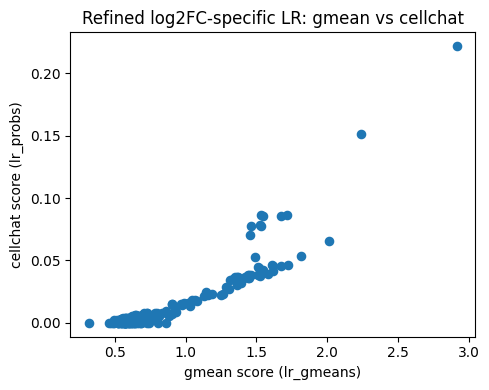

Spearman rho: 0.9008963415698864
Top20 overlap: 16 / 20

High gmean, low cellchat:


,source,target,ligand,receptor,gmean_score,cellchat_score,gmean_pvals,cellchat_pvals,rank_g,rank_c
64,NK,T_CD8_Cytotoxic,TGFB1,TGFBR3,0.858841,0.000000,0.000,1.000,65.0,126.0
68,Malignant_T,T_CD4_Naive,MIF,TNFRSF14,0.801908,0.000000,0.000,1.000,69.0,126.0
75,T_CD8_Cytotoxic,T_CD8_Cytotoxic,TGFB1,TGFBR3,0.741168,0.000000,0.000,1.000,76.0,126.0
80,T_CD8_Memory,T_CD8_Cytotoxic,TGFB1,TGFBR3,0.730068,0.000000,0.000,1.000,81.0,126.0
91,T_CD4_Naive,T_CD8_Memory,LCK,CD8B,0.688323,0.000000,0.000,1.000,92.0,126.0
92,T_CD8_Memory,T_Exhausted,CCL4,SLC7A1,0.681983,0.000000,0.000,1.000,93.0,126.0
96,T_CD8_Cytotoxic,T_CD4_Activated,TNF,FAS,0.671695,0.000000,0.000,1.000,97.0,126.0
73,Malignant_T,T_Other,LGALS9,CD44,0.747938,0.004498,0.002,0.185,74.0,99.0
72,Malignant_T,T_CD4_Activated,COPA,CD74,0.751836,0.004631,0.034,0.005,73.0,97.0
101,T_CD4_Activated,T_CD8_Cytotoxic,TGFB1,TGFBR3,0.656388,0.000000,0.000,1.000,102.0,126.0



High cellchat, low gmean:


,source,target,ligand,receptor,gmean_score,cellchat_score,gmean_pvals,cellchat_pvals,rank_g,rank_c
145,T_Other,T_CD8_Cytotoxic,LCK,CD8B,0.557875,0.003850,0.000,0.0,146.0,102.0
166,Malignant_T,NK,BAG6,NCR3,0.314592,0.000000,0.000,1.0,167.0,126.0
162,T_Resting,Malignant_T,FLT3LG,FLT3,0.491868,0.001997,0.000,0.0,163.0,123.0
165,Malignant_T,T_CD4_Naive,LGALS9,HAVCR2,0.458631,0.000000,0.000,1.0,166.0,126.0
160,T_Other,Malignant_T,FLT3LG,FLT3,0.513689,0.002243,0.000,0.0,161.0,122.0
164,T_Other,Malignant_T,TGFB1,TGFBR1,0.469763,0.000000,0.151,1.0,165.0,126.0
155,T_CD4_Naive,NK,ITGAL,ICAM3,0.533555,0.002518,0.000,0.0,156.0,118.0
163,T_CD4_Activated,Malignant_T,TGFB1,TGFBR1,0.488235,0.000000,0.051,1.0,164.0,126.0
152,T_CD4_Naive,T_CD4_Naive,ITGAL,ICAM3,0.541578,0.002818,0.000,0.0,153.0,117.0
161,T_CD8_Memory,T_Exhausted,TNF,RIPK1,0.497109,0.000000,0.000,1.0,162.0,126.0


In [74]:
import matplotlib.pyplot as plt

keys = ["source","target","ligand","receptor"]


g = res_spec[keys + ["lr_gmeans","gmean_pvals"]].rename(columns={"lr_gmeans":"gmean_score"})
c = res_ccr_spec[keys + ["lr_probs","cellchat_pvals"]].rename(columns={"lr_probs":"cellchat_score"})

m = g.merge(c, on=keys, how="inner")

print("gmean spec:", g.shape[0])
print("cellchat spec:", c.shape[0])
print("intersection:", m.shape[0])

plt.figure(figsize=(5,4))
plt.scatter(m["gmean_score"], m["cellchat_score"], s=35)
plt.xlabel("gmean score (lr_gmeans)")
plt.ylabel("cellchat score (lr_probs)")
plt.title("Refined log2FC-specific LR: gmean vs cellchat")
plt.tight_layout()
plt.show()

rho = m["gmean_score"].corr(m["cellchat_score"], method="spearman")
print("Spearman rho:", rho)

N = min(20, m.shape[0])
top_g = set(m.sort_values("gmean_score", ascending=False).head(N).apply(lambda r: tuple(r[k] for k in keys), axis=1))
top_c = set(m.sort_values("cellchat_score", ascending=False).head(N).apply(lambda r: tuple(r[k] for k in keys), axis=1))
print(f"Top{N} overlap:", len(top_g & top_c), "/", N)

m["rank_g"] = m["gmean_score"].rank(ascending=False, method="min")
m["rank_c"] = m["cellchat_score"].rank(ascending=False, method="min")
m["rank_diff"] = m["rank_g"] - m["rank_c"]

print("\nHigh gmean, low cellchat:")
display(m.sort_values("rank_diff").head(10)[keys + ["gmean_score","cellchat_score","gmean_pvals","cellchat_pvals","rank_g","rank_c"]])

print("\nHigh cellchat, low gmean:")
display(m.sort_values("rank_diff", ascending=False).head(10)[keys + ["gmean_score","cellchat_score","gmean_pvals","cellchat_pvals","rank_g","rank_c"]])